# Relationship between Food Supply and Undernourishment/Obesity Prevalence

## Samantha Jarrett

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
def confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') 
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## Preprocessing

In [3]:
under = pd.read_csv('data/FAOSTAT_undernourishment.csv')
under['Prevalence of Undernourishment'] = under['Prevalence of Undernourishment'].str.replace('<', '').astype(float)
under.isnull().sum()

Area                               0
Prevalence of Undernourishment    31
dtype: int64

In [4]:
obese = pd.read_csv('data/WHO_obesity.csv')
obese['Prevalence of Obesity'] = obese['Prevalence of Obesity'].str.replace('No', '0').astype(float)
obese.isnull().sum()

Area                     0
Prevalence of Obesity    0
dtype: int64

In [5]:
categories = {'Alcoholic Beverages': ['Beer', 'Beverages, Alcoholic', 'Beverages, Fermented', 'Wine'],
 'Beans': ['Beans', 'Cocoa Beans and products', 'Pulses, Other and products', 'Soyabeans'],
 'Dairy': ['Butter, Ghee' ,'Cream', 'Eggs', 'Milk - Excluding Butter'],
 'Fats & Oils': ['Fats, Animals, Raw', 'Coconut Oil', 'Cottonseed Oil', 'Fish, Body Oil', 'Groundnut Oil', 'Maize Germ Oil', 'Oilcrops Oil, Other', 'Oilcrops, Other', 'Olive Oil', 'Palm Oil', 'Palmkernel Oil', 'Rape and Mustard Oil', 'Rape and Mustardseed', 'Ricebran Oil', 'Sesameseed Oil', 'Soyabean Oil', 'Sunflowerseed Oil'],
 'Fruits': ['Apples and products', 'Bananas', 'Citrus, Other', 'Coconuts - Incl Copra', 'Dates', 'Fruits, other', 'Grapefruit and products', 'Grapes and products (excl wine)', 'Lemons, Limes and products', 'Oranges, Mandarines', 'Pineapples and products', 'Plantains'],
 'Grains': ['Barley and products', 'Cereals, Other', 'Maize and products', 'Millet and products', 'Oats', 'Rice and products', 'Rye and products', 'Sorghum and products', 'Wheat and products'],
 'Meat': ['Bovine Meat', 'Meat, Other', 'Mutton & Goat Meat', 'Offals, Edible', 'Pigmeat', 'Poultry Meat'],
 'Non-Alcoholic Beverages': ['Coffee and products', 'Tea (including mate)'],
 'Nuts & Seeds': ['Cottonseed', 'Groundnuts', 'Nuts and products', 'Palm kernels', 'Sesame seed', 'Sunflower seed'],
 'Other': ['Infant food', 'Miscellaneous'],
 'Seafood': ['Aquatic Animals, Others', 'Cephalopods', 'Crustaceans', 'Demersal Fish', 'Fish, Liver Oil', 'Freshwater Fish', 'Marine Fish, Other', 'Molluscs, Other', 'Pelagic Fish'], 
 'Spices': ['Cloves', 'Spices, Other'], 
 'Roots & Starches': ['Cassava and products', 'Roots, Other', 'Sweet potatoes', 'Yams'],
 'Sugars & Sweeteners': ['Honey', 'Sugar (Raw Equivalent)', 'Sugar beet', 'Sugar cane', 'Sugar non-centrifugal', 'Sweeteners, Other'],
 'Vegetables': ['Aquatic Plants', 'Olives (including preserved)', 'Onions', 'Peas', 'Pepper', 'Pimento', 'Potatoes and products', 'Tomatoes and products', 'Vegetables, other']
}

In [6]:
categories = pd.read_csv('data/categories.csv')
categories

,Category,Item
0,Alcoholic Beverages,Beer
1,Alcoholic Beverages,"Beverages, Alcoholic"
2,Alcoholic Beverages,"Beverages, Fermented"
3,Alcoholic Beverages,Wine
4,Beans,Beans
...,...,...
91,Vegetables,Pepper
92,Vegetables,Pimento
93,Roots & Starches,Potatoes and products
94,Vegetables,Tomatoes and products


In [7]:
len(categories.Category.unique())

15

In [8]:
supply = pd.read_csv('data/FAOSTAT_supply.csv')
supply.isnull().sum()

Area       0
Element    0
Item       0
Value      0
dtype: int64

In [9]:
supply = supply.merge(categories, how = 'left', on = 'Item')
supply.head()

,Area,Element,Item,Value,Category
0,Afghanistan,Food supply quantity (kg/capita/yr),Wheat and products,158.95,Grains
1,Afghanistan,Food supply (kcal/capita/day),Wheat and products,1361.66,Grains
2,Afghanistan,Protein supply quantity (g/capita/day),Wheat and products,36.71,Grains
3,Afghanistan,Fat supply quantity (g/capita/day),Wheat and products,4.55,Grains
4,Afghanistan,Food supply quantity (kg/capita/yr),Rice and products,17.21,Grains


In [10]:
kcal = supply[supply.Element == 'Food supply (kcal/capita/day)'][['Area', 'Category', 'Value']]
kcal = kcal.groupby(['Area', 'Category']).sum().reset_index()
kcal = kcal.pivot(index='Area', columns=['Category'], values='Value').fillna(0).merge(under, how='left', on = 'Area').merge(obese, how='left', on='Area')

In [11]:
kcal['Sum'] = kcal[kcal.columns[1:16]].sum(axis=1)

# Put numbers in terms of percentage
for col in kcal.columns[1:16]:
    kcal[col] = kcal[col]/kcal['Sum']

In [12]:
kcal.drop(columns = 'Sum', inplace = True)
kcal.head()

,Area,Alcoholic Beverages,Beans,Dairy,Fats & Oils,Fruits,Grains,Meat,Non-Alcoholic Beverages,Nuts & Seeds,Other,Roots & Starches,Seafood,Spices,Sugars & Sweeteners,Vegetables,Prevalence of Undernourishment,Prevalence of Obesity
0,Afghanistan,0.000036,0.008147,0.043933,0.093205,0.026463,0.685727,0.021602,0.000988,0.012887,0.000586,0.023511,0.000268,0.000550,0.066532,0.015565,30.1,5.5
1,Albania,0.016373,0.020836,0.207044,0.093138,0.087254,0.321513,0.074702,0.001125,0.012730,0.002340,0.026814,0.004620,0.000109,0.061535,0.069865,4.1,21.7
2,Algeria,0.001707,0.018248,0.079202,0.148557,0.063054,0.479542,0.028234,0.001179,0.006211,0.002128,0.036720,0.002396,0.000666,0.081552,0.050602,2.5,27.4
3,Angola,0.032253,0.032067,0.005142,0.121303,0.042956,0.315342,0.057964,0.000302,0.015290,0.001292,0.303460,0.010280,0.000066,0.056287,0.005995,21.6,8.2
4,Antigua and Barbuda,0.051070,0.016977,0.068006,0.145734,0.072670,0.299938,0.148037,0.001739,0.006849,0.005980,0.015446,0.035990,0.005887,0.101128,0.024550,NaN,18.9


## Exploratory Data Analysis
### Undernourishment

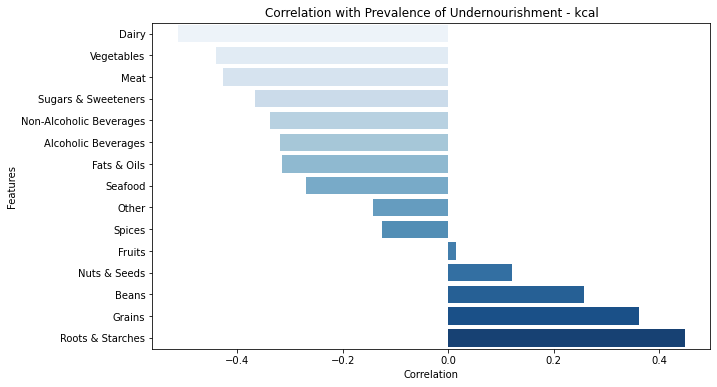

In [13]:
features = ['Alcoholic Beverages', 'Beans', 'Dairy', 'Fats & Oils',
       'Fruits', 'Grains', 'Meat', 'Non-Alcoholic Beverages', 'Nuts & Seeds',
       'Other', 'Roots & Starches', 'Seafood', 'Spices', 'Sugars & Sweeteners',
       'Vegetables']
correlations = kcal[features].corrwith(kcal['Prevalence of Undernourishment']).sort_values()

# Create a bar plot of the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, orient="h", palette = 'Blues')
plt.title('Correlation with Prevalence of Undernourishment - kcal')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

Text(0.5, 1.0, 'Histogram')

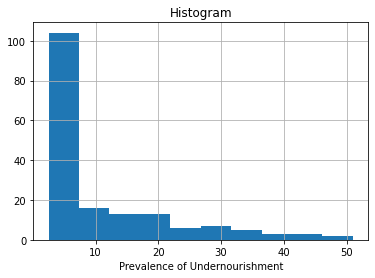

In [14]:
kcal['Prevalence of Undernourishment'].hist()
plt.xlabel('Prevalence of Undernourishment')
plt.title('Histogram')

In [15]:
kcal['Prevalence of Undernourishment'].describe()

count    172.000000
mean      10.514535
std       11.239512
min        2.500000
25%        2.500000
50%        5.150000
75%       16.125000
max       51.000000
Name: Prevalence of Undernourishment, dtype: float64

In [16]:
kcal_under = kcal[kcal['Prevalence of Undernourishment'].notna()]

condition = kcal_under['Prevalence of Undernourishment'] > 5
kcal_under['Undernourishment'] = 1 # condition met
kcal_under.loc[~condition, 'Undernourishment'] = 0  # condition not met
kcal_under['Undernourishment'].value_counts()

1    87
0    85
Name: Undernourishment, dtype: int64

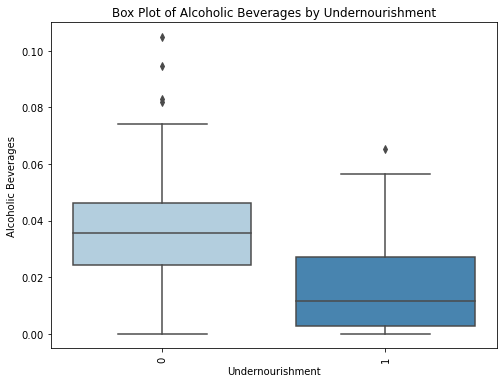

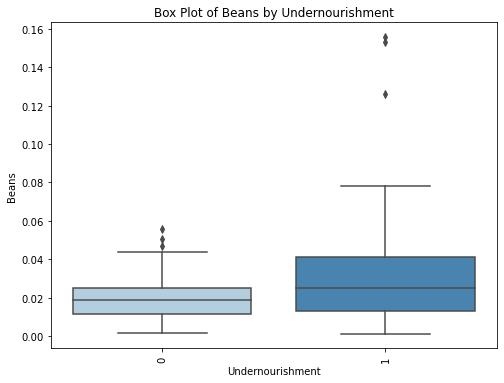

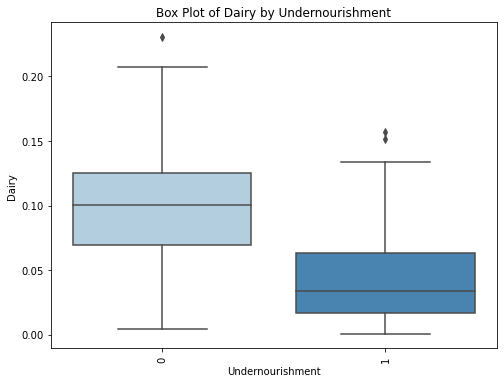

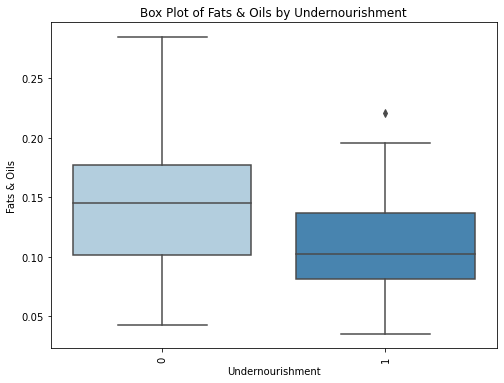

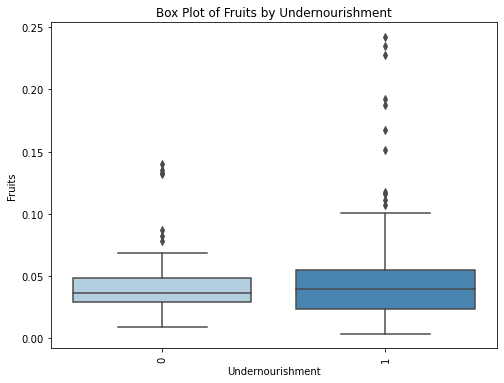

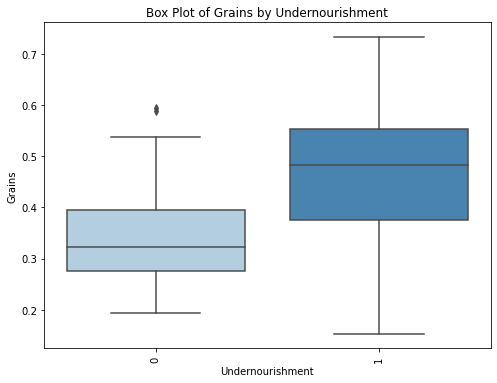

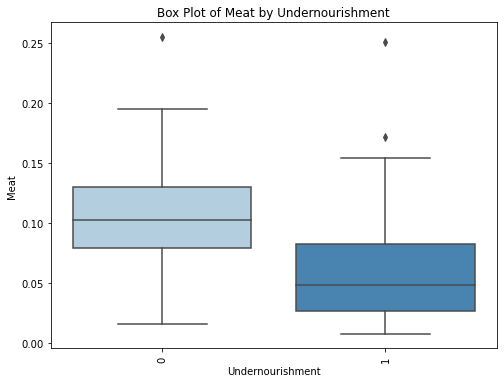

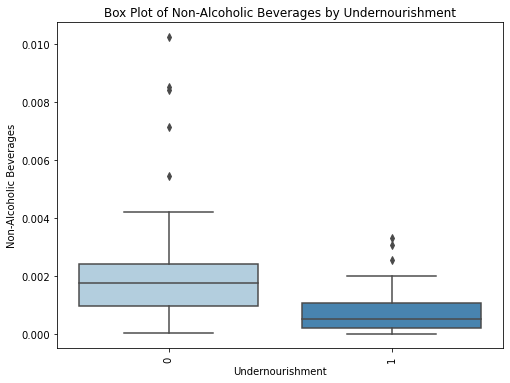

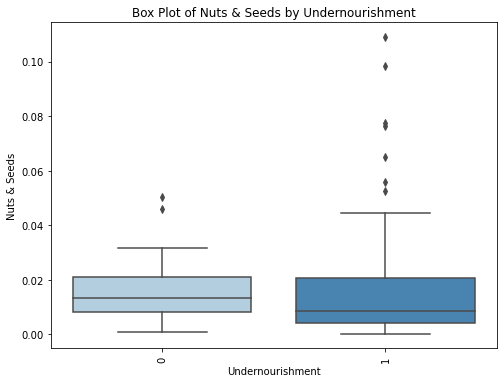

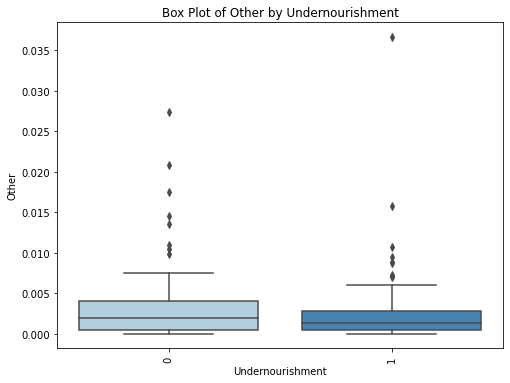

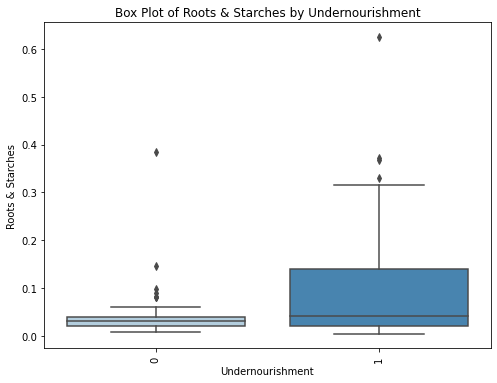

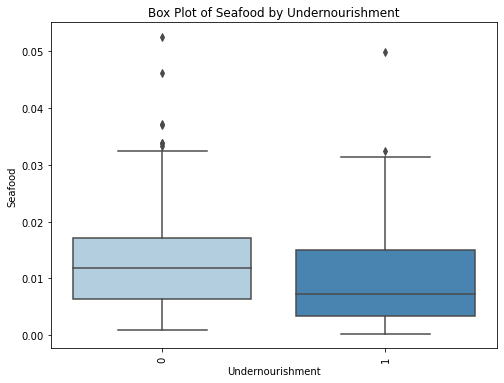

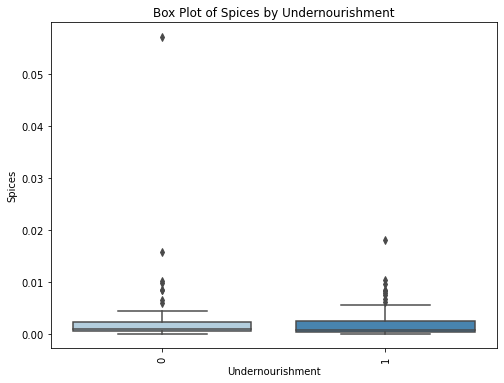

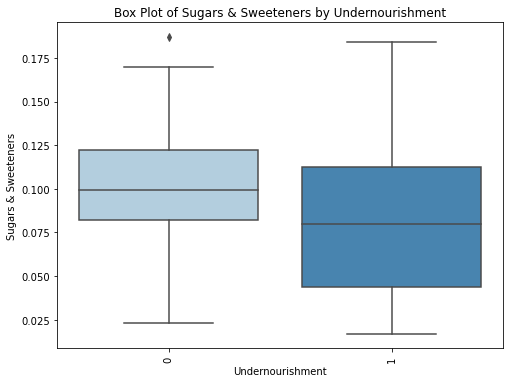

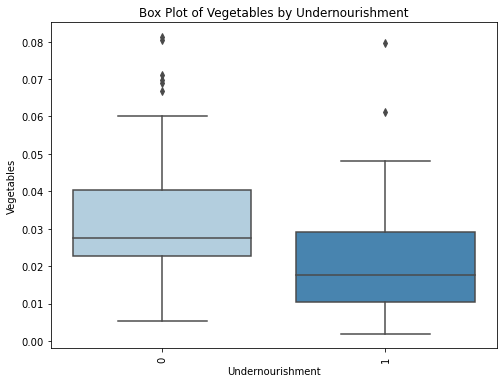

In [17]:
numerical_cols = kcal_under[features].select_dtypes(include=[np.number]).columns

for var in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Undernourishment', y=var, data=kcal_under, palette = 'Blues')
    plt.xlabel('Undernourishment')
    plt.ylabel(var.title())
    plt.xticks(rotation=90)
    plt.title(f'Box Plot of {var.title()} by Undernourishment')
    plt.show()

### Obesity

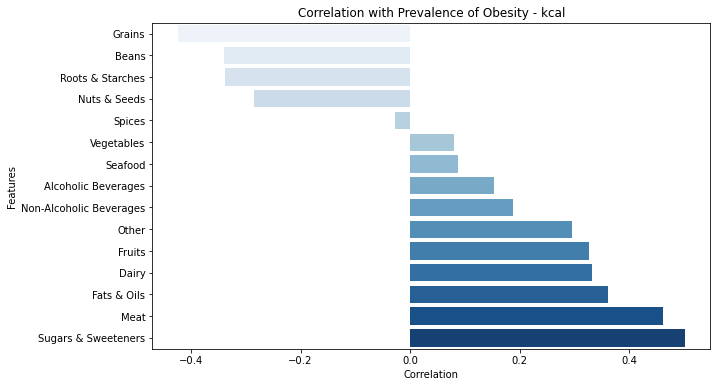

In [18]:
correlations = kcal[features].corrwith(kcal['Prevalence of Obesity']).sort_values()

# Create a bar plot of the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, orient="h", palette = 'Blues')
plt.title('Correlation with Prevalence of Obesity - kcal')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

Text(0.5, 1.0, 'Histogram')

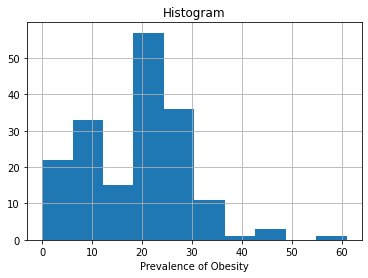

In [19]:
kcal['Prevalence of Obesity'].hist()
plt.xlabel('Prevalence of Obesity')
plt.title('Histogram')

In [22]:
kcal['Prevalence of Obesity'].describe()

count    179.000000
mean      19.008380
std       10.098798
min        0.000000
25%        9.550000
50%       20.600000
75%       25.100000
max       61.000000
Name: Prevalence of Obesity, dtype: float64

In [23]:
kcal_obese = kcal[kcal['Prevalence of Obesity'].notna()]

condition = kcal_obese['Prevalence of Obesity'] > 20
kcal_obese['Obesity'] = 1 # condition met
kcal_obese.loc[~condition, 'Obesity'] = 0  # condition not met
kcal_obese['Obesity'].value_counts()

1    97
0    82
Name: Obesity, dtype: int64

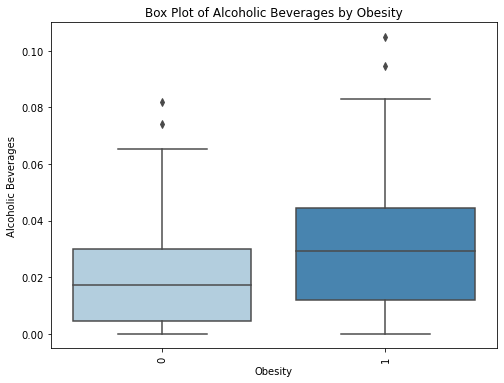

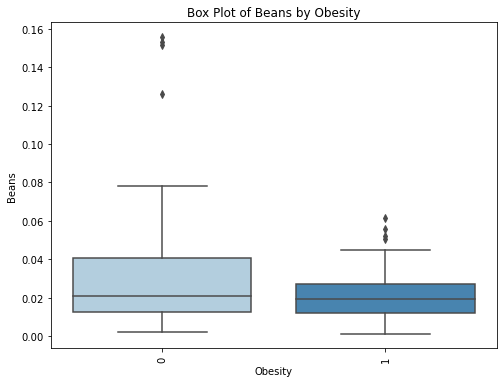

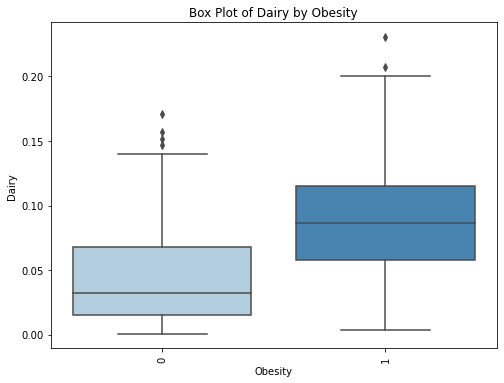

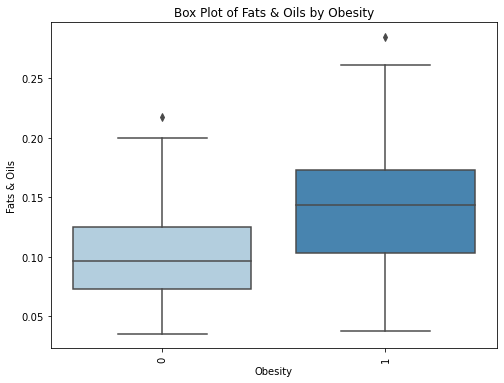

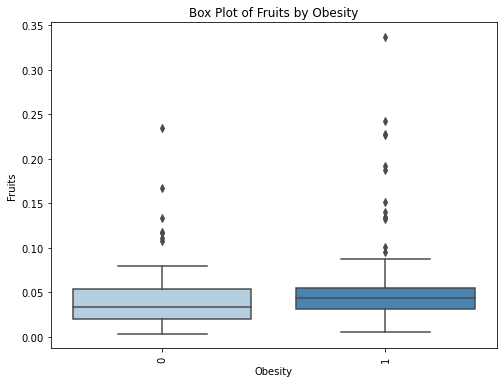

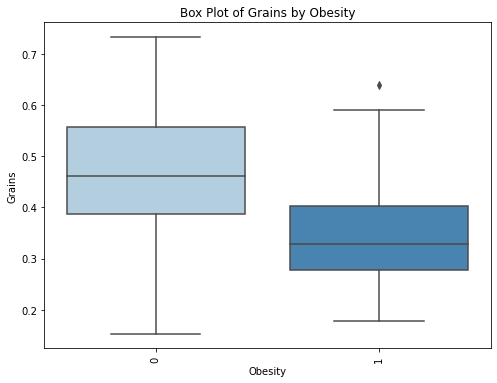

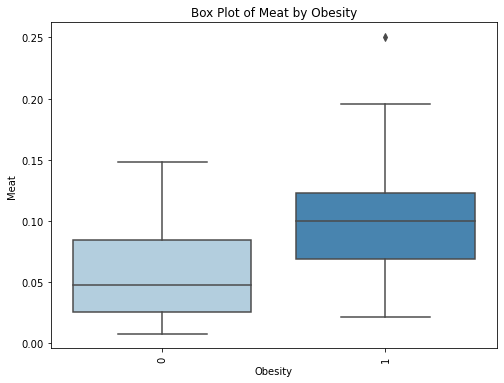

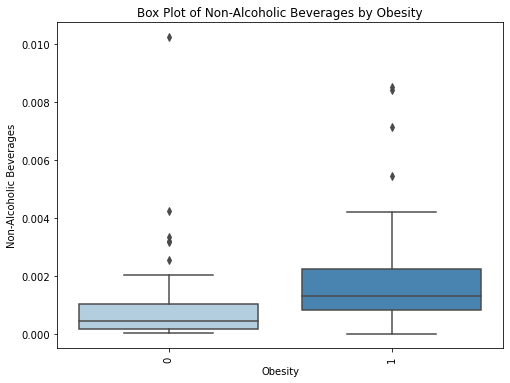

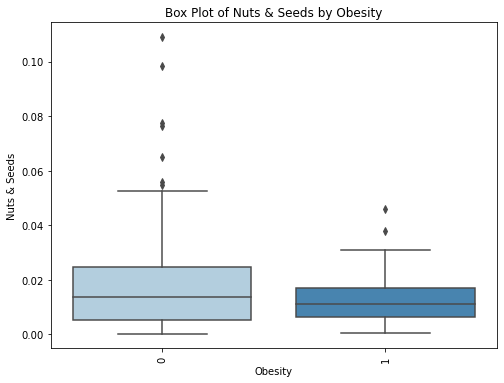

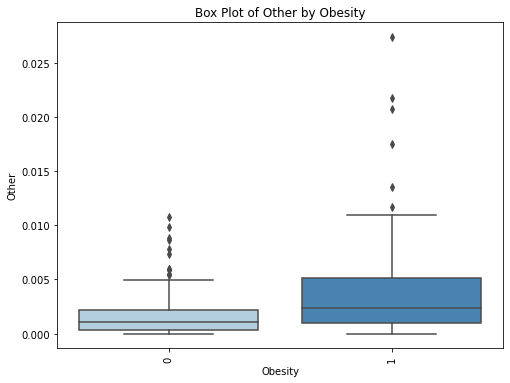

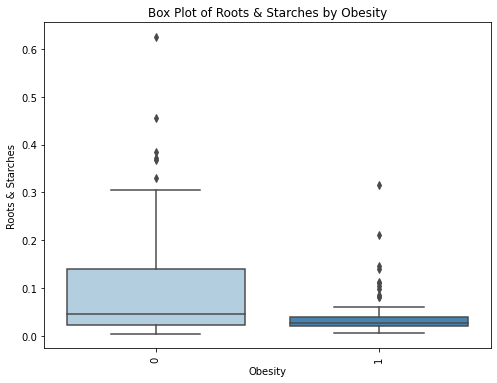

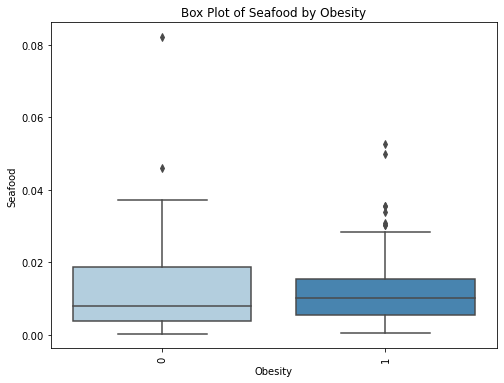

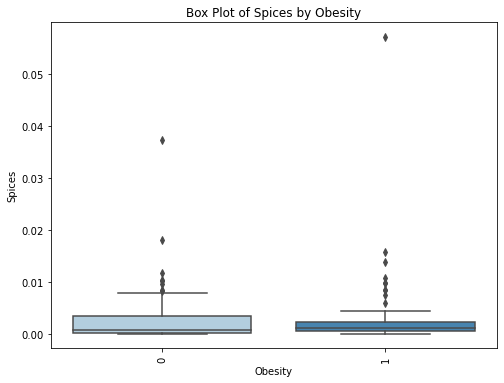

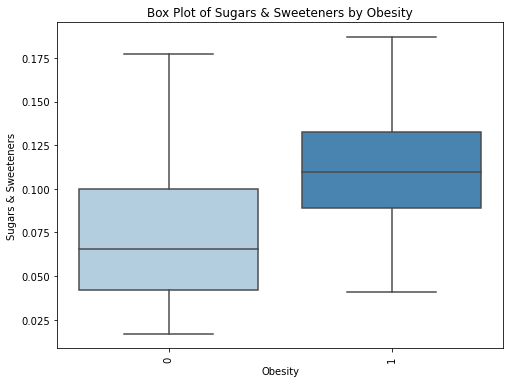

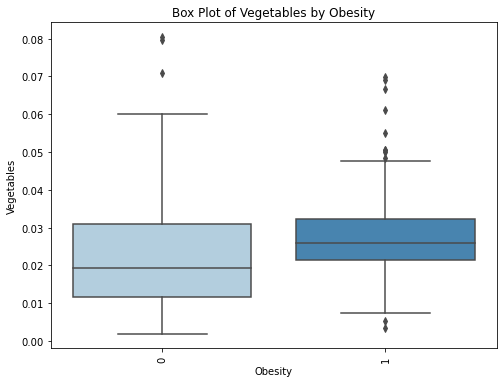

In [24]:
numerical_cols = kcal_obese[features].select_dtypes(include=[np.number]).columns

for var in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Obesity', y=var, data=kcal_obese, palette = 'Blues')
    plt.xlabel('Obesity')
    plt.ylabel(var.title())
    plt.xticks(rotation=90)
    plt.title(f'Box Plot of {var.title()} by Obesity')
    plt.show()

In [162]:
kcal[['Area','Prevalence of Obesity', 'Prevalence of Undernourishment']].sort_values(by = 'Prevalence of Obesity',
                                                                                     ascending = True).head(10)

,Area,Prevalence of Obesity,Prevalence of Undernourishment
159,Sudan,0.0,11.9
156,South Sudan,0.0,21.4
182,Viet Nam,2.1,5.0
12,Bangladesh,3.6,11.2
166,Timor-Leste,3.8,22.3
78,India,3.9,16.6
27,Cambodia,3.9,4.8
118,Nepal,4.1,5.4
86,Japan,4.3,3.2
58,Ethiopia,4.5,21.9


In [25]:
kcal[['Area','Prevalence of Obesity', 'Prevalence of Undernourishment']].sort_values(by = 'Prevalence of Obesity',
                                                                                     ascending = False).head(10)

,Area,Prevalence of Obesity,Prevalence of Undernourishment
117,Nauru,61.0,NaN
145,Samoa,47.3,4.6
90,Kiribati,46.0,12.1
110,Micronesia (Federated States of),45.8,NaN
91,Kuwait,37.9,2.5
177,United States of America,36.2,2.5
87,Jordan,35.5,NaN
147,Saudi Arabia,35.4,3.8
136,Qatar,35.1,NaN
98,Libya,32.5,8.4


In [161]:
kcal[['Area','Prevalence of Obesity', 'Prevalence of Undernourishment']].sort_values(by = 'Prevalence of Undernourishment',
                                                                                     ascending = True).head(40)

,Area,Prevalence of Obesity,Prevalence of Undernourishment
83,Israel,26.1,2.5
112,Montenegro,23.3,2.5
109,Mexico,28.9,2.5
100,Luxembourg,22.6,2.5
42,Croatia,24.4,2.5
43,Cuba,24.6,2.5
44,Cyprus,21.8,2.5
45,Czechia,26.0,2.5
99,Lithuania,26.3,2.5
179,Uzbekistan,16.6,2.5


In [26]:
kcal[['Area','Prevalence of Obesity', 'Prevalence of Undernourishment']].sort_values(by = 'Prevalence of Undernourishment',
                                                                                     ascending = False).head(10)

,Area,Prevalence of Obesity,Prevalence of Undernourishment
101,Madagascar,5.3,51.0
30,Central African Republic,7.5,48.7
96,Lesotho,16.6,46.0
47,Democratic People's Republic of Korea,6.8,45.5
74,Haiti,22.7,45.0
185,Zimbabwe,15.5,38.4
97,Liberia,9.9,38.4
72,Guinea-Bissau,9.5,37.9
48,Democratic Republic of the Congo,6.7,35.3
183,Yemen,17.1,34.5


## Classification - Undernourishment

In [59]:
X = kcal_under[['Alcoholic Beverages', 'Beans', 'Dairy', 'Fats & Oils', 'Fruits', 'Grains', 'Meat', 'Non-Alcoholic Beverages', 
                'Nuts & Seeds', 'Other', 'Roots & Starches', 'Seafood', 'Spices', 'Sugars & Sweeteners', 'Vegetables']]
y = kcal_under['Undernourishment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
k_best = SelectKBest(score_func=chi2, k='all')
X_train_selected = k_best.fit_transform(X_train, y_train)
feature_scores = k_best.scores_
feature_names =X.columns
feature_ranking = list(zip(feature_names, feature_scores))
feature_ranking.sort(key=lambda x: x[1], reverse=True)

for i, (feature_name, score) in enumerate(feature_ranking):
    print(f"Rank {i + 1}: {feature_name} (Score: {score:.2f})")

Rank 1: Dairy (Score: 1.87)
Rank 2: Roots & Starches (Score: 1.30)
Rank 3: Grains (Score: 1.26)
Rank 4: Meat (Score: 0.86)
Rank 5: Alcoholic Beverages (Score: 0.41)
Rank 6: Fats & Oils (Score: 0.35)
Rank 7: Beans (Score: 0.23)
Rank 8: Vegetables (Score: 0.19)
Rank 9: Sugars & Sweeteners (Score: 0.11)
Rank 10: Fruits (Score: 0.07)
Rank 11: Non-Alcoholic Beverages (Score: 0.06)
Rank 12: Seafood (Score: 0.05)
Rank 13: Spices (Score: 0.02)
Rank 14: Other (Score: 0.01)
Rank 15: Nuts & Seeds (Score: 0.00)


In [126]:
# Selected Features
#X = kcal_under[['Roots & Starches',  'Dairy', 'Grains']]
X = kcal_under[['Roots & Starches',  'Dairy', 'Grains', 'Meat', 'Alcoholic Beverages', 'Fats & Oils',
               'Beans']]
y = kcal_under['Undernourishment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [112]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

log_classifier = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(estimator=log_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_lr_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
#confusion(y_test, y_pred)

Best Parameters:
{'C': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.71      0.86      0.77        14

    accuracy                           0.80        35
   macro avg       0.80      0.81      0.80        35
weighted avg       0.82      0.80      0.80        35



In [113]:
print(X.columns)
best_lr_model.coef_

Index(['Roots & Starches', 'Dairy', 'Grains', 'Meat', 'Alcoholic Beverages',
       'Fats & Oils', 'Beans'],
      dtype='object')


array([[ 5.27893736, -6.18231794,  6.46632652, -3.74376237, -1.56298776,
        -1.76688696,  1.84957108]])

### KNN

Best Parameters:
{'n_neighbors': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.64      0.78        14

    accuracy                           0.86        35
   macro avg       0.90      0.82      0.84        35
weighted avg       0.88      0.86      0.85        35



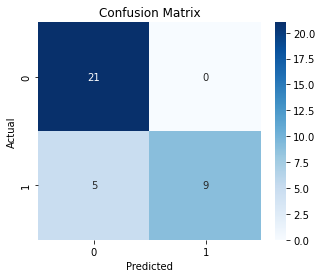

In [114]:
param_grid = {
    'n_neighbors': [2, 4, 6, 8]
}

knn_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_knn_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

### Decision Tree

In [115]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [None, 2, 3, 4, 5], 
    'criterion': ['gini', 'entropy']  
}

dt_classifier = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_dt_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
#confusion(y_test, y_pred)

Best Parameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 4}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.79      0.79      0.79        14

    accuracy                           0.83        35
   macro avg       0.82      0.82      0.82        35
weighted avg       0.83      0.83      0.83        35



### Random Forest

In [116]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [None, 2, 3, 4, 5]
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
#confusion(y_test, y_pred)

Best Parameters:
{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.79      0.79      0.79        14

    accuracy                           0.83        35
   macro avg       0.82      0.82      0.82        35
weighted avg       0.83      0.83      0.83        35



### Gradient Boosting

Best Parameters:
{'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.79      0.79      0.79        14

    accuracy                           0.83        35
   macro avg       0.82      0.82      0.82        35
weighted avg       0.83      0.83      0.83        35



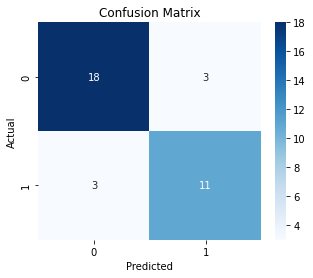

In [117]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.2, 0.4, 0.8],
}

gboost_classifier = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gboost_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Best Parameters:')
print(best_params)

best_gboost_model = grid_search.best_estimator_
y_pred = best_gboost_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

## Classification - Obesity

In [118]:
X = kcal_obese[['Alcoholic Beverages', 'Beans', 'Dairy', 'Fats & Oils', 'Fruits', 'Grains', 'Meat', 'Non-Alcoholic Beverages', 
                'Nuts & Seeds', 'Other', 'Roots & Starches', 'Seafood', 'Spices', 'Sugars & Sweeteners', 'Vegetables']]
y = kcal_obese['Obesity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
k_best = SelectKBest(score_func=chi2, k='all')
X_train_selected = k_best.fit_transform(X_train, y_train)
feature_scores = k_best.scores_
feature_names =X.columns
feature_ranking = list(zip(feature_names, feature_scores))
feature_ranking.sort(key=lambda x: x[1], reverse=True)

for i, (feature_name, score) in enumerate(feature_ranking):
    print(f"Rank {i + 1}: {feature_name} (Score: {score:.2f})")

Rank 1: Roots & Starches (Score: 1.91)
Rank 2: Grains (Score: 1.50)
Rank 3: Dairy (Score: 1.21)
Rank 4: Meat (Score: 0.77)
Rank 5: Fats & Oils (Score: 0.68)
Rank 6: Sugars & Sweeteners (Score: 0.49)
Rank 7: Fruits (Score: 0.26)
Rank 8: Beans (Score: 0.24)
Rank 9: Alcoholic Beverages (Score: 0.18)
Rank 10: Nuts & Seeds (Score: 0.12)
Rank 11: Other (Score: 0.03)
Rank 12: Non-Alcoholic Beverages (Score: 0.02)
Rank 13: Vegetables (Score: 0.01)
Rank 14: Spices (Score: 0.00)
Rank 15: Seafood (Score: 0.00)


In [151]:
X = kcal_obese[['Roots & Starches',  'Dairy', 'Grains', 'Meat', 'Fats & Oils', 'Sugars & Sweeteners']]
y = kcal_obese['Obesity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

Best Parameters:
{'C': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        16
           1       0.74      0.70      0.72        20

    accuracy                           0.69        36
   macro avg       0.69      0.69      0.69        36
weighted avg       0.70      0.69      0.70        36



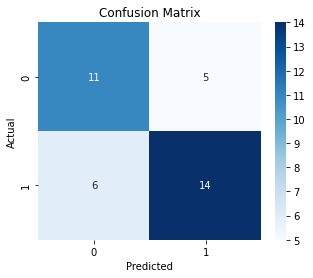

In [152]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

log_classifier = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(estimator=log_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_lr_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

In [153]:
print(X.columns)
best_lr_model.coef_

Index(['Roots & Starches', 'Dairy', 'Grains', 'Meat', 'Fats & Oils',
       'Sugars & Sweeteners'],
      dtype='object')


array([[ -8.64382697,   4.38427566, -11.54736125,   1.12697177,
          7.68538489,   7.88345782]])

### KNN

In [154]:
param_grid = {
    'n_neighbors': [2, 4, 6, 8]
}

knn_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_knn_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
#confusion(y_test, y_pred)

Best Parameters:
{'n_neighbors': 8}
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.78      0.70      0.74        20

    accuracy                           0.72        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.73      0.72      0.72        36



### Decision Tree

In [155]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [None, 2, 3, 4, 5], 
    'criterion': ['gini', 'entropy']  
}

dt_classifier = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_dt_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
#confusion(y_test, y_pred)

Best Parameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        16
           1       0.74      0.70      0.72        20

    accuracy                           0.69        36
   macro avg       0.69      0.69      0.69        36
weighted avg       0.70      0.69      0.70        36



### Random Forest

Best Parameters:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.79      0.75      0.77        20

    accuracy                           0.75        36
   macro avg       0.75      0.75      0.75        36
weighted avg       0.75      0.75      0.75        36



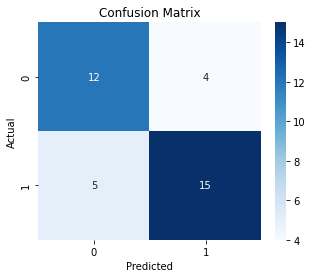

In [158]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [None, 2, 3, 4, 5]
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print('Best Parameters:')
print(best_params)

y_pred = best_rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

### Gradient Boosting

Best Parameters:
{'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 300}
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.78      0.70      0.74        20

    accuracy                           0.72        36
   macro avg       0.72      0.72      0.72        36
weighted avg       0.73      0.72      0.72        36



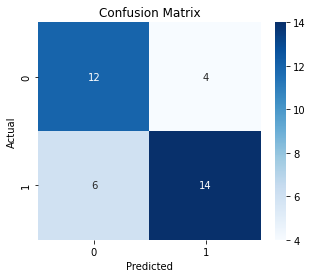

In [157]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.2, 0.4, 0.8],
}

gboost_classifier = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gboost_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Best Parameters:')
print(best_params)

best_gboost_model = grid_search.best_estimator_
y_pred = best_gboost_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)